In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from scipy.stats import norm
import matplotlib.pyplot as plt
from io import open
import glob
import os, sys
import unicodedata
import string
import time
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from random import randint
from torch.autograd import Variable
import numpy as np
from numpy.random import shuffle
from common import *
from datasets.hanoi import *
from models.d1 import *

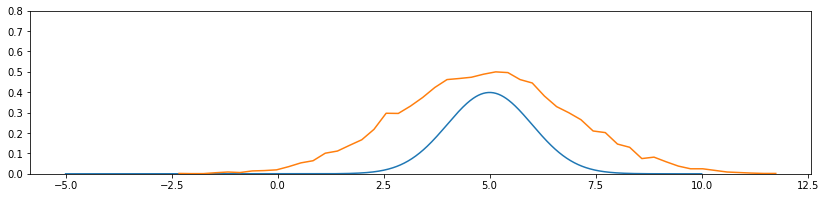

In [2]:
def compare_dist(true_mu, emp_vals, bins=50):
    hcount, havg = np.histogram(emp_vals, bins=bins)
    hcount = hcount.astype(np.float32)
    hcount /= np.max(hcount)
    hcount *= 0.5

    x = np.linspace(-5, 10, 1000)
    gfunc = norm.pdf(x, loc = 5, scale = 1)

    plt.figure(figsize=(14, 3))
    plt.ylim(0, 0.8)
    plt.plot(x, gfunc)
    plt.plot(havg[:-1], hcount)
    plt.show()
    plt.close()

rand_samples = torch.randn(10000, 1)*2 + 5
rand_samples = rand_samples.squeeze().cpu().numpy().tolist()
compare_dist(5, rand_samples)

In [3]:
BSIZE = 64
LR = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bhalf = BSIZE // 2
real_labels = Variable(torch.ones(bhalf, 1), requires_grad=False).to(device)
fake_labels = Variable(torch.zeros(bhalf, 1), requires_grad=False).to(device)
adversarial_loss = torch.nn.BCELoss().to(device)

In [4]:
spawn = SpawnNet().to(device)
discrim = DiscrimNet().to(device)

gen_opt = optim.Adam([
    { 'params': spawn.parameters() },
], lr=1e-5, weight_decay=1e-4)

discrim_opt = optim.Adam([
    { 'params': discrim.parameters() },
], lr=1e-5, weight_decay=1e-4)

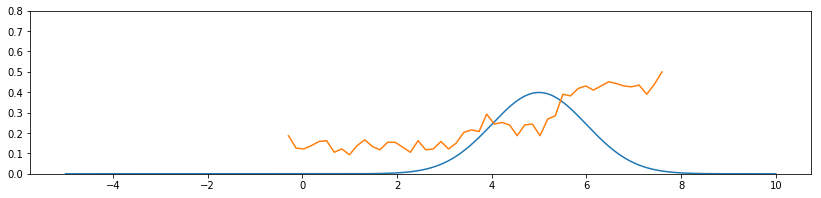

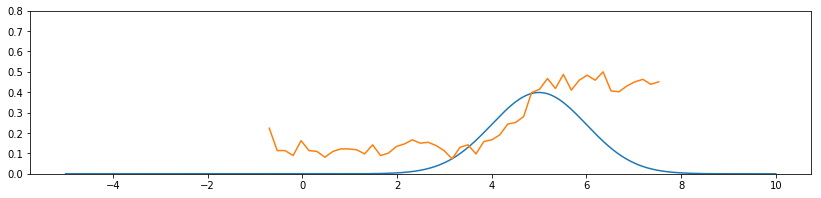

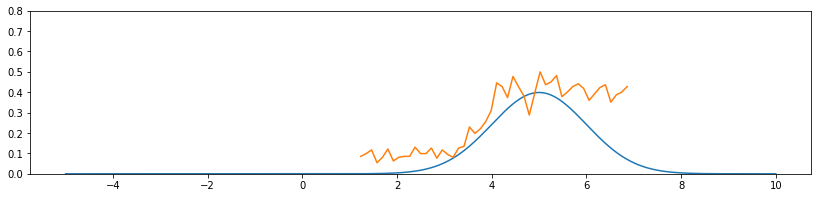

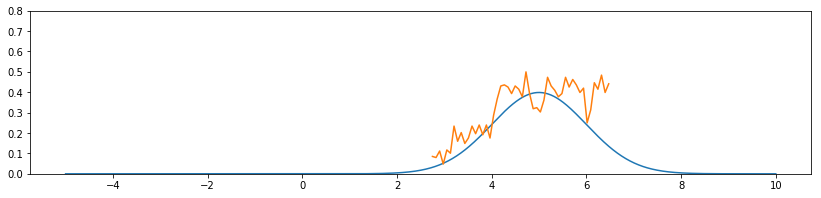

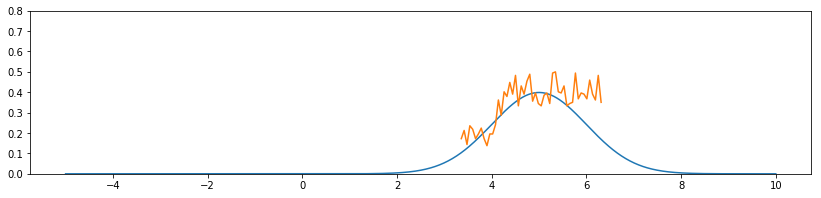

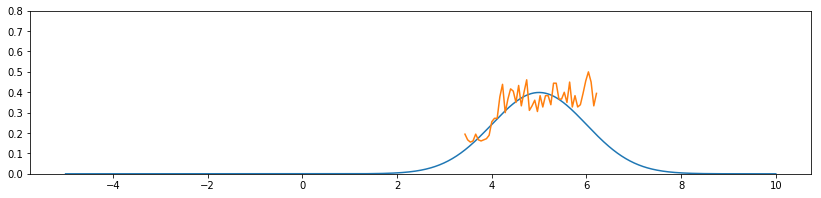

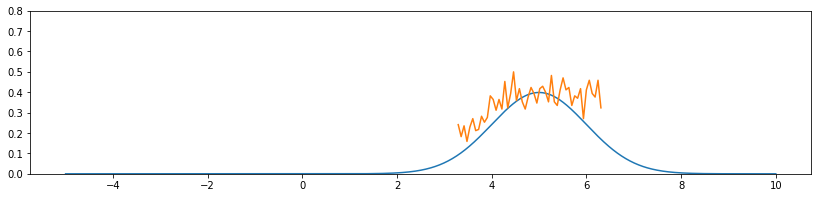

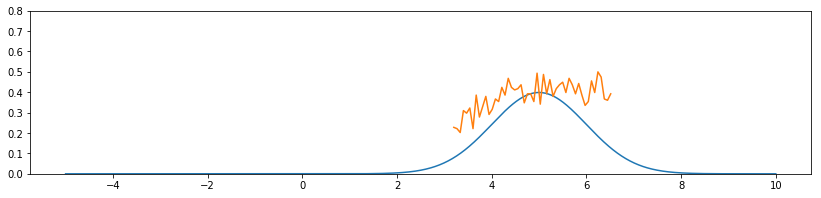

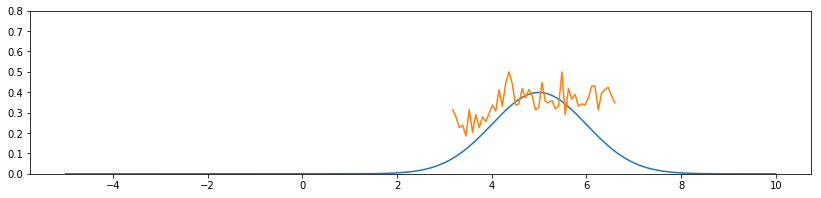

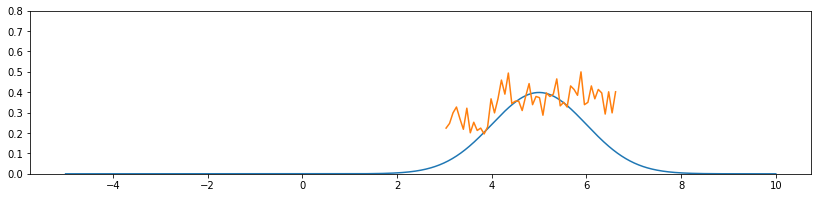

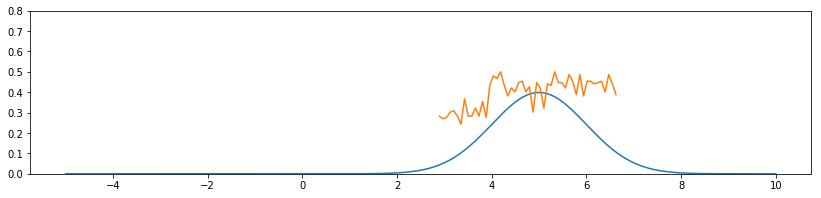

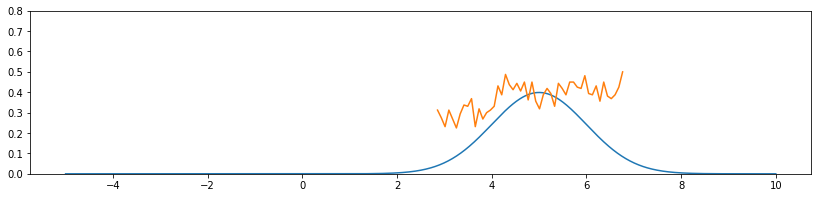

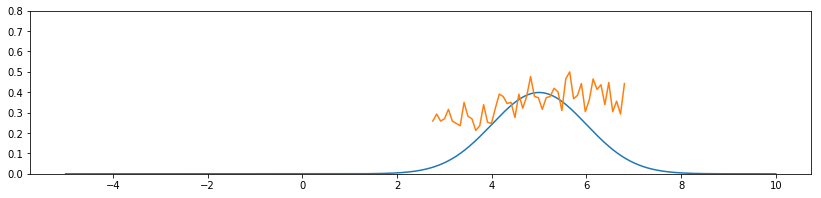

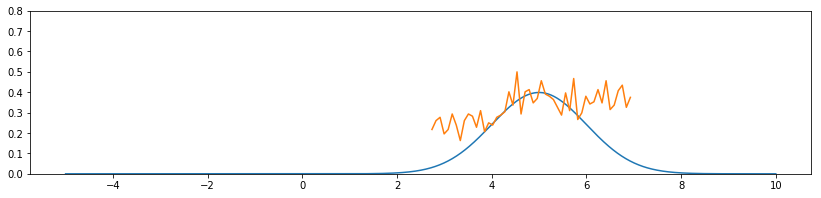

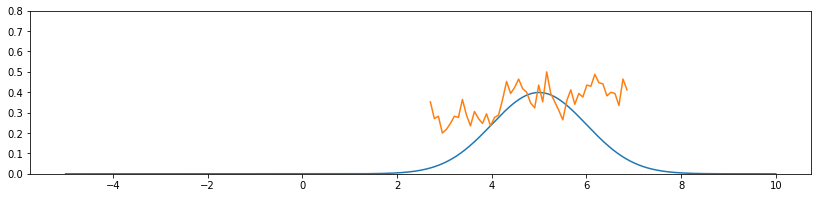

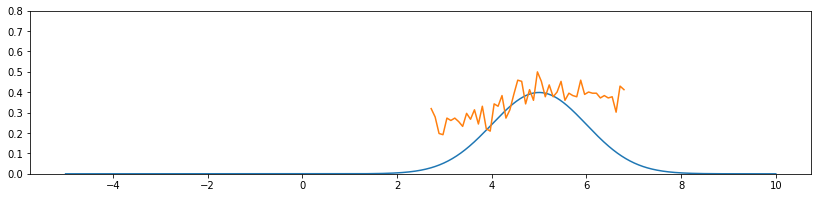

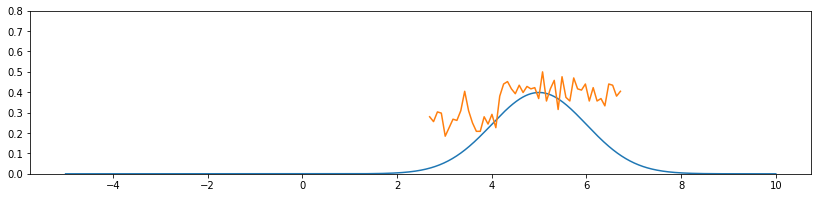

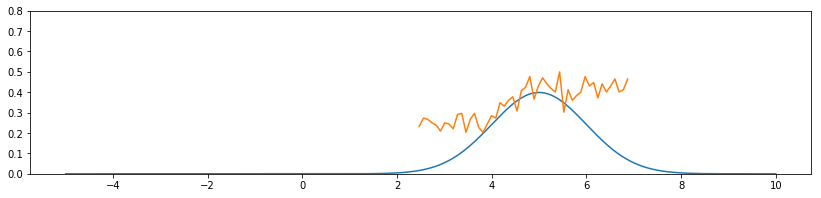

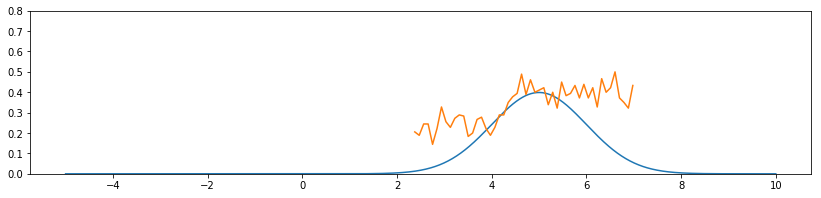

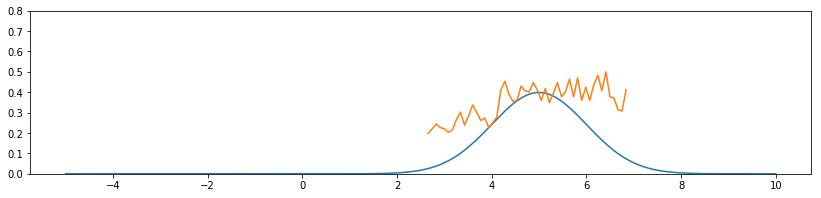

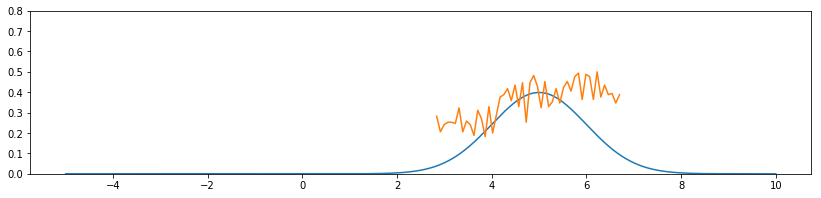

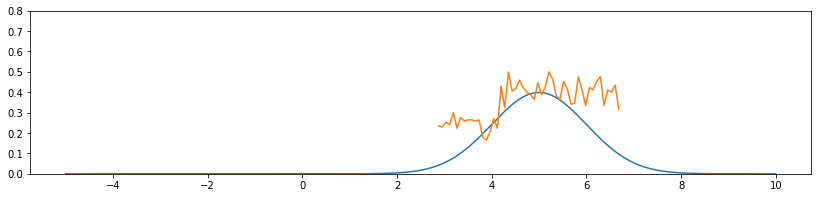

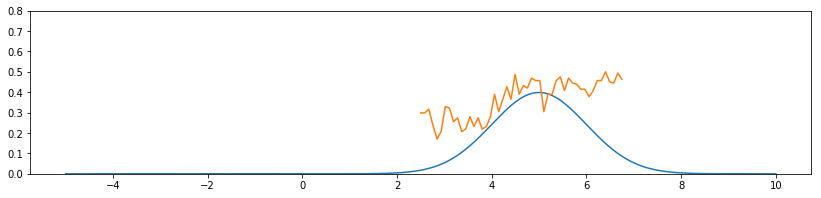

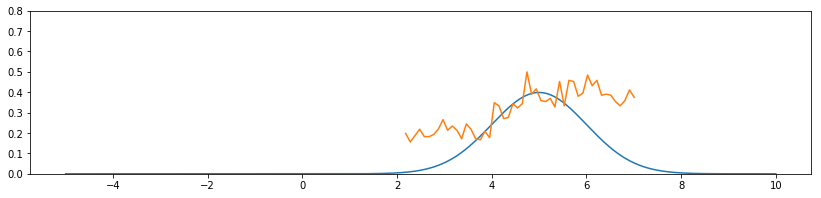

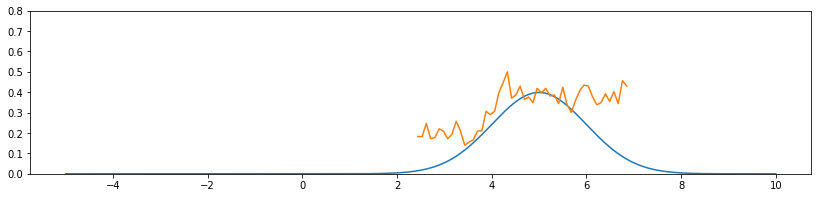

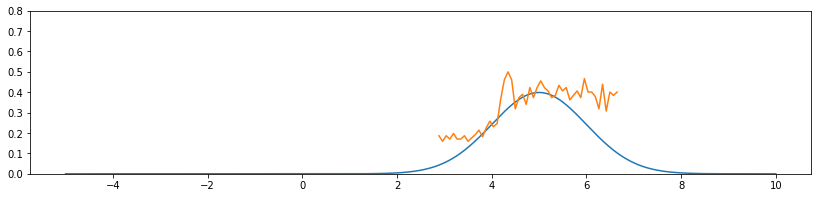

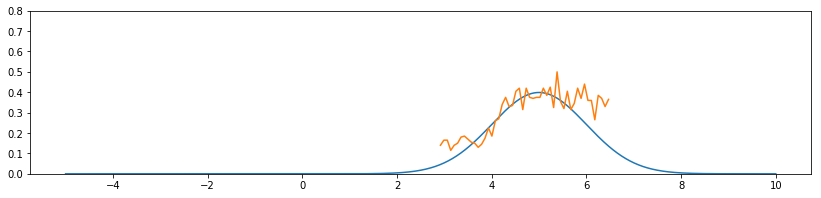

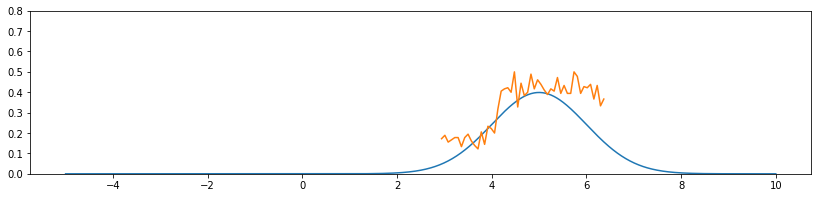

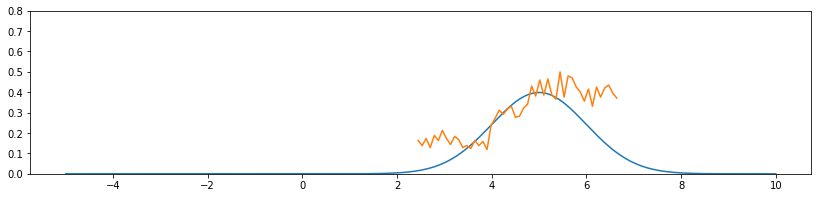

In [ ]:
def preview():
    fake_samples = []
    for ii in range(3000):
        zin = spawn.init_noise().to(device)
        zout = spawn(zin)
        fake_samples.append(zout.detach().squeeze().cpu().numpy().tolist())
    
    compare_dist(5, fake_samples)

n_iters = 100 * 1000
for iter in range(1, n_iters + 1):
    if iter == 1:
        preview()
        
    spawn.zero_grad()

    real_samples = (torch.randn(bhalf, 1) + 5).to(device)
    fake_samples = []
    for _ in range(bhalf):
        zin = spawn.init_noise().to(device)
        fake_zout = spawn(zin)
        fake_samples.append(fake_zout)
    fake_samples = torch.stack(fake_samples).to(device)
    
    # -- Generator Training --
    gen_loss = adversarial_loss(discrim(fake_samples), real_labels)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()
    
    # -- Discrimination Training --
    # NOTE: Readout gradients carry over to discriminiator training
    discrim.zero_grad()

    real_guesses = discrim(real_samples)
    real_loss = adversarial_loss(real_guesses, real_labels)
    fake_guesses = discrim(fake_samples.detach())
    fake_loss = adversarial_loss(fake_guesses, fake_labels)
    discrim_loss = (real_loss + fake_loss) / 2
    discrim_loss.backward()
    discrim_opt.step()
    
    real_score = score(real_guesses, real_labels)
    fake_score = score(fake_guesses, fake_labels)
    disc_score = (real_score + fake_score) / 2
    assert disc_score <= 1.0
    
    if iter % 10 == 0:
        sys.stdout.write('[%d] Generate/L: %.5f  Discrim/L : %.5f  Score: %.2f   \r' % (
            iter,
            gen_loss.item(),
            discrim_loss.item(),
            disc_score))
        
    if iter % 2500 == 0:
        preview()
    
#     break